## 📦 Setup

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from dotenv import load_dotenv
from matplotlib.ticker import ScalarFormatter

# Add project root to path
sys.path.insert(0, os.path.abspath('..'))

from nlp.embeddings import EmbeddingGenerator

load_dotenv()

# Configuration
PROJECT_ID = os.getenv('GCP_PROJECT_ID', 'sg-job-market')
DATASET_ID = os.getenv('BQ_DATASET_ID', 'sg_job_market')

print("✅ Imports successful")
print(f"Project: {PROJECT_ID}")
print(f"Dataset: {DATASET_ID}")

✅ Imports successful
Project: sg-job-market
Dataset: sg_job_market


## 📊 Load Embeddings from BigQuery

In [3]:
client = bigquery.Client(project=PROJECT_ID)

query = f"""
SELECT 
    e.job_id,
    e.source,
    e.embedding,
    e.model_name,
    e.created_at,
    c.job_title,
    c.company_name,
    c.job_location,
    c.job_classification
FROM `{PROJECT_ID}.{DATASET_ID}.job_embeddings` e
JOIN `{PROJECT_ID}.{DATASET_ID}.cleaned_jobs` c
    ON e.job_id = c.job_id AND e.source = c.source
LIMIT 1000
"""

print("Loading embeddings from BigQuery...")
df = client.query(query).to_dataframe()

print(f"\n✅ Loaded {len(df):,} jobs with embeddings")
print(f"Embedding dimension: {len(df['embedding'].iloc[0])}")
print(f"\nSample data:")
df[['job_title', 'company_name', 'job_classification']].head()

Loading embeddings from BigQuery...


c:\Users\User\Documents\SG_Job_Market\.venv\Lib\site-packages\google\cloud\bigquery\table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



✅ Loaded 1,000 jobs with embeddings
Embedding dimension: 384

Sample data:


,job_title,company_name,job_classification
0,Legal Counsel (AI Technology),STAFFKING .,Legal
1,APAC Legal Manager,UPS ASIA GROUP .,Legal
2,Process Engineer,DR LASER SINGAPORE .,Precision Engineering
3,"Senior Associate, Real Estate",WEE HUR CAPITAL .,Real Estate / Property Management
4,Event Executive/Planner (Event Company / 5D / ...,NALA EMPLOYMENT .,Entertainment


## 🔍 Test Similarity Search

Find jobs similar to a query using cosine similarity.

In [4]:
# Generate embedding for query
generator = EmbeddingGenerator()
query_text = "Senior Data Scientist with Python and machine learning experience"

print(f"Query: {query_text}")
print("\nGenerating query embedding...")
query_embedding = generator.embed_texts([query_text])

print(f"> Embedded matrix: {query_embedding}")
print(f"\n> Query embedding shape: {query_embedding.shape}")

# Since we only have one query, we take the first row
query_embedding = query_embedding[0]
print(f"\n> Query embedding vector shape: {query_embedding.shape}")

Query: Senior Data Scientist with Python and machine learning experience

Generating query embedding...


c:\Users\User\Documents\SG_Job_Market\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 1/1 [00:00<00:00, 58.38it/s]

> Embedded matrix: [[-8.14497843e-02  2.61427164e-02  6.16718084e-02  6.67643771e-02
  -7.61197461e-03 -1.44538581e-01 -4.00911644e-02 -3.23459655e-02
  -1.56884685e-01 -4.77438755e-02 -7.87186027e-02 -2.34097075e-02
   4.63907644e-02 -1.95023045e-02  3.21459547e-02  1.08191848e-01
  -1.01614125e-01 -2.46658474e-02  4.78268042e-03 -1.20968275e-01
  -4.70162444e-02 -7.23217847e-03 -1.41038913e-02 -4.45014313e-02
   6.55130595e-02 -3.91232856e-02  3.53042148e-02  6.23796768e-02
  -2.10496597e-02  3.39972600e-02 -2.86967829e-02 -2.79243384e-02
  -1.50212394e-02  5.38915880e-02  1.80311850e-03  4.46798392e-02
   3.91765647e-02 -1.21125979e-02 -1.43404044e-02  5.75038269e-02
  -1.42612681e-02  4.15800698e-03 -2.92154448e-03 -3.96813937e-02
  -1.01660015e-02 -5.27241128e-03  1.32119376e-02 -1.17309138e-01
   4.90341075e-02 -3.39578018e-02 -2.83774007e-02 -3.30944881e-02
  -4.23823996e-03 -9.11882073e-02 -4.46428433e-02 -1.81986819e-04
   7.47091696e-02 -3.39747220e-03  3.03726504e-03 -1.1072

In [5]:
print("> Original embeddings from df (taking only the first 2 elements):")
print(df['embedding'].values[:2])
print(f"\n> Number of embeddings: {len(df['embedding'].values)}")

# We do a vertical stack to convert list of arrays into 2D array
embeddings_matrix = np.vstack(df['embedding'].values)

print ("\n> Embedded matrix from df:")
print(embeddings_matrix)
print(f"\n> Embeddings matrix shape: {embeddings_matrix.shape}")

> Original embeddings from df (taking only the first 2 elements):
[array([-4.98189405e-02, -8.26002844e-03, -1.19957756e-02, -7.47045502e-02,
        -2.42943838e-02,  4.51588146e-02, -2.37924866e-02,  2.65324414e-02,
         7.46911094e-02, -1.71521213e-04, -9.39833820e-02,  2.76090913e-02,
        -6.56824410e-02,  7.22736493e-02,  8.15652907e-02,  6.16131686e-02,
         1.46569237e-02, -4.28696796e-02, -2.10201032e-02, -2.84688156e-02,
        -2.85437256e-02,  4.25332561e-02, -4.87634726e-02, -3.78681906e-02,
        -6.03517853e-02, -5.73646314e-02,  2.95113921e-02, -1.04266353e-01,
        -9.63155180e-03, -8.36342424e-02,  3.69902328e-03, -6.32960489e-03,
         8.28375816e-02,  3.20356786e-02,  3.16617899e-02,  5.21520246e-03,
         1.30629074e-02, -2.21475605e-02,  2.71570906e-02, -1.21300546e-02,
         2.30636299e-02,  3.16173807e-02, -5.63575551e-02, -8.73859692e-03,
         2.47015562e-02, -2.18418427e-02,  3.24706808e-02,  8.60431325e-03,
        -1.11844903e-0

In [6]:
# Calculate cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity([query_embedding], embeddings_matrix)

print(f"> Similarities: {similarities}")
print(f"\n> Similarities shape: {similarities.shape}")

# Since we have only one query, take the first row
similarities = similarities[0]
print(f"\n> Similarity scores vector shape: {similarities.shape}")

# Add similarity scores to dataframe
df['similarity'] = similarities

# See similarity column
df[['job_title', 'company_name', 'similarity']].head()

# Get top 10 similar jobs
# Note: Similarity is based on embeddings generated from job_title + job_description,
# but we show other fields (company, classification, location) for context
top_jobs_all = df.nlargest(10, 'similarity')

top_jobs = top_jobs_all[['job_title', 'company_name', 'job_classification', 'job_location', 'similarity']]

print(f"\n🎯 Top 10 Similar Jobs:\n")
print(f"{'Score':<6}| {'Job Title':<50} | {'Company':<30} | {'Location':<30} | {'Category':<30}")
print("-" * 150)
for idx, row in top_jobs.iterrows():
    print(f"{row['similarity']:.3f} | {row['job_title'][:50]:50} | {row['company_name'][:30]:30} | {row['job_location'][:30]:30} | {row['job_classification'][:30]:30}")

> Similarities: [[0.14289598 0.12907358 0.26456749 0.25516181 0.22652122 0.13514232
  0.15129247 0.15765203 0.17922829 0.24934899 0.24627376 0.33266054
  0.22969097 0.12263706 0.22178008 0.31607992 0.23396333 0.16545512
  0.15321566 0.18213985 0.2177883  0.18104303 0.11164427 0.14597535
  0.16192417 0.21179878 0.27630021 0.16252996 0.23146529 0.22055401
  0.18871398 0.18871398 0.28930348 0.24525706 0.17235134 0.18291511
  0.15639377 0.21078868 0.29931567 0.15714591 0.27347454 0.28817914
  0.30622114 0.17392272 0.26955963 0.31568726 0.24329909 0.18274226
  0.19629595 0.1971802  0.29055571 0.18549929 0.18821278 0.34740999
  0.28817914 0.28999597 0.19683777 0.17938461 0.23936083 0.23028879
  0.22099174 0.30571012 0.24515056 0.26179318 0.25261338 0.21759889
  0.23936083 0.30031046 0.21341658 0.28325707 0.21953545 0.14898081
  0.24550145 0.22370703 0.29591555 0.17869746 0.26874839 0.31634489
  0.21222317 0.14826318 0.26051972 0.28563528 0.23199854 0.39469307
  0.11907139 0.13165333 0.195683

## 🔍 Verify Dataset Composition

Check if the sample actually contains Data Scientist jobs.

In [7]:
# Check if our sample contains actual Data Scientist jobs
print("🔍 Checking for Data Scientist jobs in sample...\n")

# Search for jobs with "Data Scientist" in title
data_scientist_jobs = df[df['job_title'].str.contains('Data Scientist', case=False, na=False)]
print(f"Jobs with 'Data Scientist' in title: {len(data_scientist_jobs)}")

if len(data_scientist_jobs) > 0:
    print("\n📋 Data Scientist jobs found:")
    print(data_scientist_jobs[['job_title', 'company_name', 'job_classification']].to_string(index=False))
    
    # Calculate similarity between query and actual Data Scientist jobs
    if len(data_scientist_jobs) > 0:
        ds_indices = data_scientist_jobs.index
        ds_similarities = df.loc[ds_indices, 'similarity'].values
        print(f"\n📊 Similarity scores for Data Scientist jobs:")
        print(f"  Mean: {ds_similarities.mean():.3f}")
        print(f"  Max: {ds_similarities.max():.3f}")
        print(f"  Min: {ds_similarities.min():.3f}")
else:
    print("⚠️ No 'Data Scientist' jobs in this sample of 1000!")
    print("   This explains why similarity scores are low.")
    
# Search for related ML/AI jobs
ml_jobs = df[df['job_title'].str.contains('Machine Learning|ML Engineer|AI Engineer|Data Science', case=False, na=False)]
print(f"\n🤖 Jobs with ML/AI keywords in title: {len(ml_jobs)}")

if len(ml_jobs) > 0:
    print("\n📋 Sample ML/AI jobs:")
    print(ml_jobs[['job_title', 'company_name', 'similarity']].head(10).to_string(index=False))

🔍 Checking for Data Scientist jobs in sample...

Jobs with 'Data Scientist' in title: 0
⚠️ No 'Data Scientist' jobs in this sample of 1000!
   This explains why similarity scores are low.

🤖 Jobs with ML/AI keywords in title: 1

📋 Sample ML/AI jobs:
                           job_title                     company_name  similarity
Research Engineer (Machine Learning) NANYANG TECHNOLOGICAL UNIVERSITY    0.281639


## 🎯 Test with Better Query

Let's try a query that matches jobs actually in the dataset.

In [8]:
# Pick a common job title from the dataset (after lowercasing) and test similarity
common_titles = df['job_title'].str.lower().value_counts().head(10)
print("📊 Top 10 most common job titles in sample:")
print(common_titles)

# Test with a title that exists in dataset
test_query = "answer any query from client efficiently through tickets and calls"
print(f"\n🔍 Testing with: '{test_query}'")

test_embedding = generator.embed_texts([test_query])[0]
test_similarities = cosine_similarity([test_embedding], embeddings_matrix)[0]
df['test_similarity'] = test_similarities

test_top_jobs = df.nlargest(10, 'test_similarity')[['job_title', 'company_name', 'test_similarity']]

print(f"\n🎯 Top 10 Similar Jobs:\n")
for idx, row in test_top_jobs.iterrows():
    print(f"{row['test_similarity']:.3f} | {row['job_title'][:60]:60} | {row['company_name'][:30]:30}")

📊 Top 10 most common job titles in sample:
job_title
supervisor                    24
assistant cook                10
beautician                     9
chef                           6
project engineer               4
customer service executive     4
bim modeller                   3
site engineer                  3
restaurant manager             3
foot reflexologist             3
Name: count, dtype: int64

🔍 Testing with: 'answer any query from client efficiently through tickets and calls'


Batches: 100%|██████████| 1/1 [00:00<00:00, 180.07it/s]


🎯 Top 10 Similar Jobs:

0.344 | Ticketing & Reservation Executive                            | ALKANAAH INTERNATIONAL TOURS &
0.291 | Front Desk Receptionist (Resort)                             | SENTOSA BEACH RESORT          
0.283 | Network Support (Rotating Shift)| West                       | GMP TECHNOLOGIES (S)          
0.282 | Reservation Executive                                        | SENTOSA BEACH RESORT          
0.271 | Customer Service Representative                              | YOGA MOVEMENT .               
0.264 | 🍷 Event Server (VIP Service) | Up to $20/hr                  | HRNET VENTURES .              
0.256 | Executive, Finance (Accounts Receivable)                     | OMEGA INTEGRATION             
0.253 | Transaction Manager                                          | WATIGA & CO. (S) .            
0.250 | Sales Hunters (HORECA)                                       | FIELD CATERING & SUPPLIES     
0.250 | Customer Service/Sales Executive                 

## 📈 Embedding Quality Checks

📊 Embedding Statistics:

Shape: (1000, 384)
Value range: [-0.223, 0.241]
Mean: -0.001
Std: 0.051

📏 Vector Norms: 1.000 (Means)
Std: 0.000
Min: 1.000
Max: 1.000

✅ Embeddings are properly normalized (unit vectors)


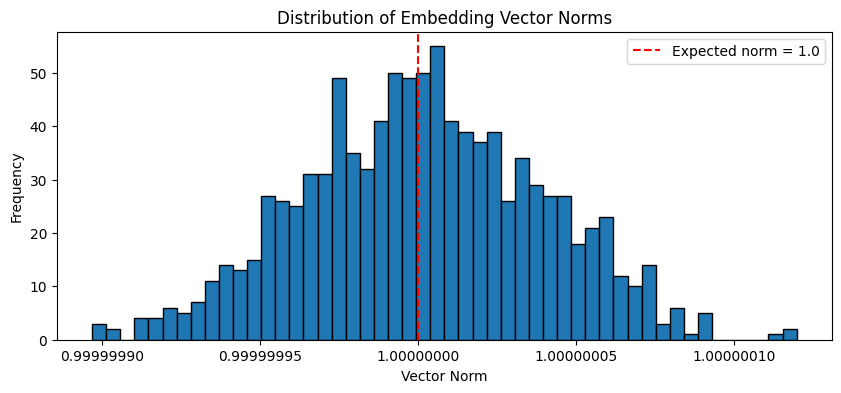

In [10]:
# Check embedding statistics
embeddings_matrix = np.vstack(df['embedding'].values)

print("📊 Embedding Statistics:\n")
print(f"Shape: {embeddings_matrix.shape}")
print(f"Value range: [{embeddings_matrix.min():.3f}, {embeddings_matrix.max():.3f}]")
print(f"Mean: {embeddings_matrix.mean():.3f}")
print(f"Std: {embeddings_matrix.std():.3f}")

# Check normalization (SBERT embeddings should have norm ≈ 1)
norms = np.linalg.norm(embeddings_matrix, axis=1)
print(f"\n📏 Vector Norms: {norms.mean():.3f} (Means)")
# print(f"Mean: {norms.mean():.3f}")
print(f"Std: {norms.std():.3f}")
print(f"Min: {norms.min():.3f}")
print(f"Max: {norms.max():.3f}")

if abs(norms.mean() - 1.0) < 0.01:
    print("\n✅ Embeddings are properly normalized (unit vectors)")
else:
    print("\n⚠️ Warning: Embeddings may not be normalized")

# Plot norm distribution
plt.figure(figsize=(10, 4))
plt.hist(norms, bins=50, edgecolor='black')
plt.axvline(1.0, color='red', linestyle='--', label='Expected norm = 1.0')

# Get the current axis and apply the formatter
ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

plt.xlabel('Vector Norm')
plt.ylabel('Frequency')
plt.title('Distribution of Embedding Vector Norms')
plt.legend()
plt.show()

## 🔬 Understanding L2 Norm vs Embedding Values

Let's visualize the difference between embedding values and their norms.

📊 One Embedding Vector:

First 10 values: [-0.04981894 -0.00826003 -0.01199578 -0.07470455 -0.02429438  0.04515881
 -0.02379249  0.02653244  0.07469111 -0.00017152]

📏 Individual Values:
  Min: -0.133  ← Can be negative!
  Max: 0.153  ← Can be positive!
  Range: [-0.133, 0.153]

🔢 L2 Norm Calculation:
  Sum of 384 squared values: 1.000
  L2 norm = √1.000 = 1.000

✅ L2 norm is always POSITIVE (it's a length!)


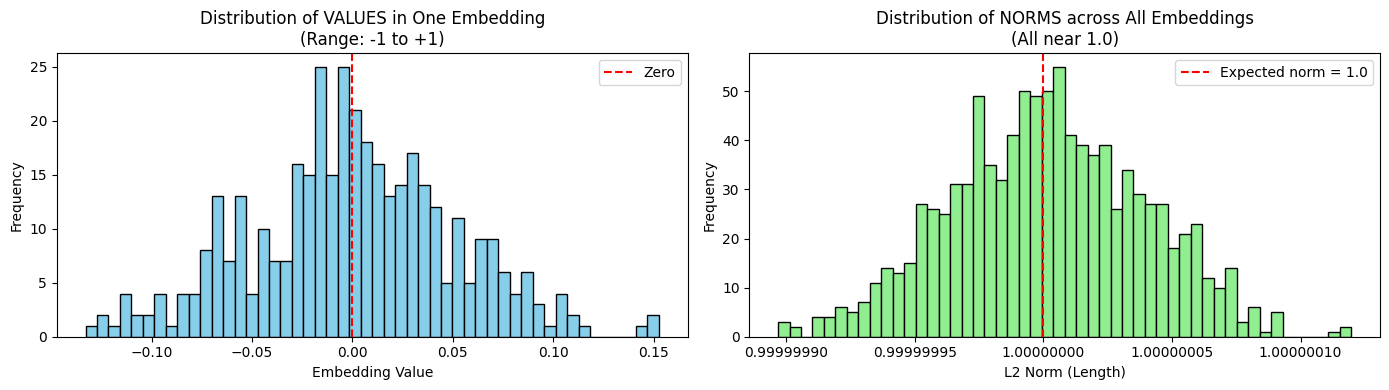


KEY DIFFERENCE:
  Left: Individual embedding VALUES (can be -1 to +1)
  Right: L2 NORMS of embeddings (always positive, near 1.0)


In [11]:


# Take one embedding to demonstrate
sample_embedding = embeddings_matrix[0]  # 384 values

print("📊 One Embedding Vector:\n")
print(f"First 10 values: {sample_embedding[:10]}")
print(f"\n📏 Individual Values:")
print(f"  Min: {sample_embedding.min():.3f}  ← Can be negative!")
print(f"  Max: {sample_embedding.max():.3f}  ← Can be positive!")
print(f"  Range: [{sample_embedding.min():.3f}, {sample_embedding.max():.3f}]")

# Calculate L2 norm manually
squared_values = sample_embedding ** 2  # Square each value
sum_of_squares = squared_values.sum()   # Add them all
l2_norm = np.sqrt(sum_of_squares)       # Take square root

print(f"\n🔢 L2 Norm Calculation:")
print(f"  Sum of 384 squared values: {sum_of_squares:.3f}")
print(f"  L2 norm = √{sum_of_squares:.3f} = {l2_norm:.3f}")
print(f"\n✅ L2 norm is always POSITIVE (it's a length!)")

# Visualize both
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left plot: Individual embedding values
axes[0].hist(sample_embedding, bins=50, edgecolor='black', color='skyblue')
axes[0].axvline(0, color='red', linestyle='--', label='Zero')
axes[0].set_xlabel('Embedding Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of VALUES in One Embedding\n(Range: -1 to +1)')
axes[0].legend()

# Right plot: Norms of all embeddings
axes[1].hist(norms, bins=50, edgecolor='black', color='lightgreen')
axes[1].axvline(1.0, color='red', linestyle='--', label='Expected norm = 1.0')
axes[1].xaxis.set_major_formatter(ScalarFormatter(useOffset=False)) # To show exact number
axes[1].set_xlabel('L2 Norm (Length)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of NORMS across All Embeddings\n(All near 1.0)')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY DIFFERENCE:")
print("  Left: Individual embedding VALUES (can be -1 to +1)")
print("  Right: L2 NORMS of embeddings (always positive, near 1.0)")
print("="*70)

## 🎨 Visualize Embeddings with PCA

PC1 (23.4% variance) might represent: "Technical vs Non-Technical"  
   x = -5.0  →  Highly technical (Software Engineer, Data Scientist)  
   x =  0.0  →  Neutral (Project Manager, Business Analyst)  
   x = +5.0  →  Non-technical (Sales, HR, Admin)  

PC2 (12.1% variance) might represent: "Seniority vs Entry-Level"  
   y = +4.0  →  Senior roles (Director, Lead, Principal)  
   y =  0.0  →  Mid-level  
   y = -4.0  →  Junior/Entry-level  

Reducing 384 dimensions to 2D with PCA...
✅ Explained variance: 12.41%


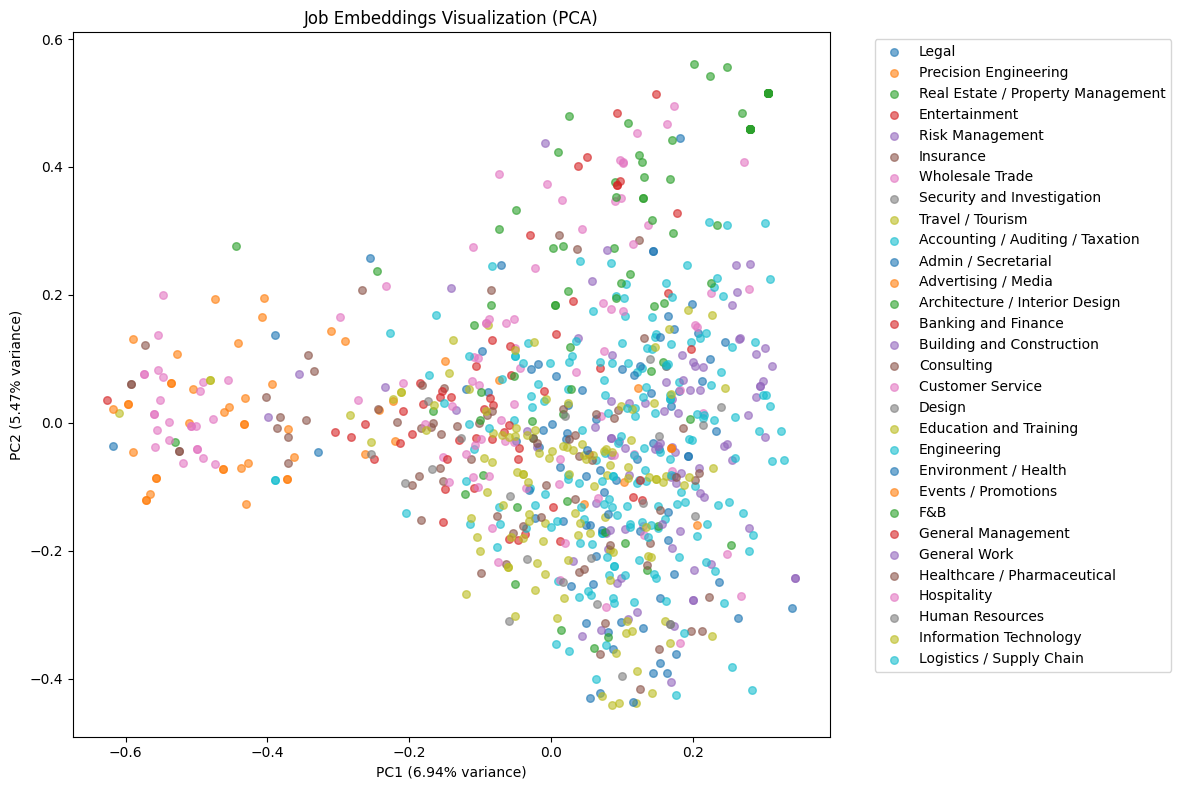

In [18]:
# Reduce to 2D using PCA
print("Reducing 384 dimensions to 2D with PCA...")
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embeddings_matrix)

df['pca_1'] = embeddings_2d[:, 0]
df['pca_2'] = embeddings_2d[:, 1]


print(f"✅ Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# Good values:
# >30% total variance in 2D → Good separation
# <20% total variance → Data is very high-dimensional, 2D plot may be misleading

# Plot by job classification
plt.figure(figsize=(12, 8))
for classification in df['job_classification'].dropna().unique()[:30]:
    subset = df[df['job_classification'] == classification]
    plt.scatter(subset['pca_1'], subset['pca_2'], 
                label=classification, alpha=0.6, s=30) # Alpha = transparency level, s = size

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Job Embeddings Visualization (PCA)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # bbox_to_anchor to place legend outside of x, y # loc is allignment
plt.tight_layout()
plt.show()

## 🎯 Analyze Similarity by Category


📊 Intra-Category Similarity (Higher = More Cohesive):

                        category  count  avg_similarity
                             F&B     69        0.536551
Accounting / Auditing / Taxation     53        0.492092
       Building and Construction     68        0.410835
          Education and Training     47        0.404552
          Information Technology     65        0.404174
                  Sales / Retail     43        0.398270
             Admin / Secretarial     66        0.392350
                     Engineering     97        0.379302
                Customer Service     91        0.379056
                      Consulting     44        0.378576


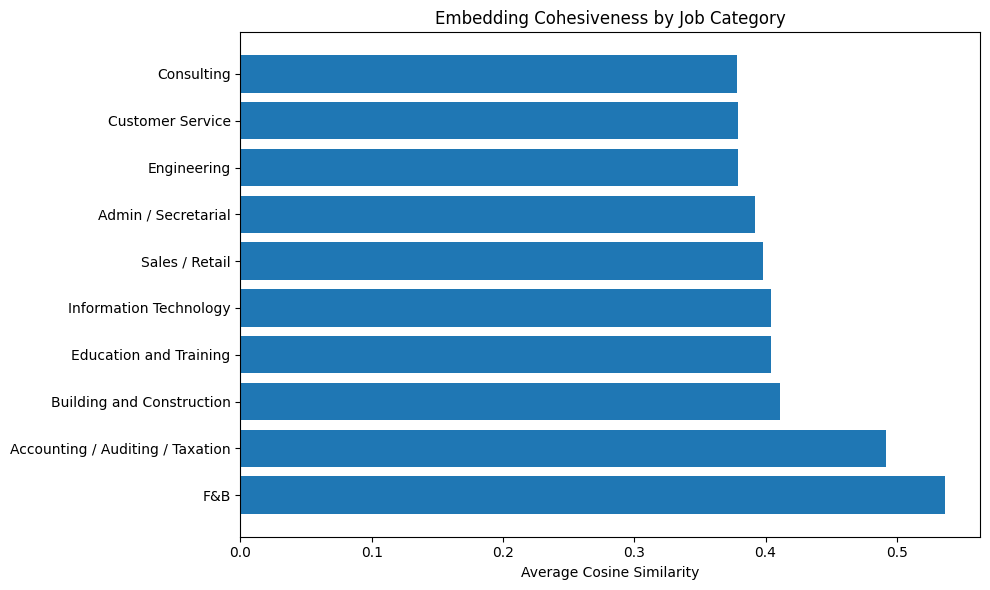

In [21]:
# Group by job classification and check intra-cluster similarity
from sklearn.metrics.pairwise import cosine_similarity

def calculate_intra_cluster_similarity(df, classification):
    """Calculate average similarity within a job classification."""
    subset = df[df['job_classification'] == classification]
    if len(subset) < 2:
        return np.nan
    
    embeddings = np.vstack(subset['embedding'].values)
    sim_matrix = cosine_similarity(embeddings)
    
    # Get upper triangle (exclude diagonal)
    mask = np.triu(np.ones_like(sim_matrix, dtype=bool), k=1)
    return sim_matrix[mask].mean()

# Calculate for top categories
top_categories = df['job_classification'].value_counts().head(10).index
similarity_scores = []

for cat in top_categories:
    score = calculate_intra_cluster_similarity(df, cat)
    similarity_scores.append({
        'category': cat,
        'count': len(df[df['job_classification'] == cat]),
        'avg_similarity': score
    })

sim_df = pd.DataFrame(similarity_scores).sort_values('avg_similarity', ascending=False)

print("\n📊 Intra-Category Similarity (Higher = More Cohesive):\n")
print(sim_df.to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sim_df['category'], sim_df['avg_similarity'])
plt.xlabel('Average Cosine Similarity')
plt.title('Embedding Cohesiveness by Job Category')
plt.tight_layout()
plt.show()

## 💾 Summary Statistics

In [23]:
print("\n" + "="*70)
print("📋 EMBEDDING PIPELINE SUMMARY")
print("="*70)

print(f"\n✅ Total Jobs with Embeddings: {len(df):,}")
print(f"✅ Embedding Dimension: {len(df['embedding'].iloc[0])}")
print(f"✅ Model: {df['model_name'].iloc[0]}")
print(f"✅ Sources: {df['source'].unique().tolist()}")
print(f"\n📊 Job Categories: {df['job_classification'].nunique()}")
print(f"📊 Companies: {df['company_name'].nunique()}")
print(f"📊 Locations: {df['job_location'].nunique()}")

print(f"\n🎯 Quality Metrics:")
print(f"  Vector norm: {norms.mean():.3f} ± {norms.std():.3f} (expected: 1.0)")
print(f"  Value range: [{embeddings_matrix.min():.3f}, {embeddings_matrix.max():.3f}]")
print(f"  PCA variance (2D): {pca.explained_variance_ratio_.sum():.2%}")


📋 EMBEDDING PIPELINE SUMMARY

✅ Total Jobs with Embeddings: 1,000
✅ Embedding Dimension: 384
✅ Model: all-MiniLM-L6-v2
✅ Sources: ['MCF']

📊 Job Categories: 40
📊 Companies: 459
📊 Locations: 27

🎯 Quality Metrics:
  Vector norm: 1.000 ± 0.000 (expected: 1.0)
  Value range: [-0.223, 0.241]
  PCA variance (2D): 12.41%
